# Two-layer network with universality + Jacobian

This notebook simply shows that, empirically, a two-layer network with sigmoidal activation functions can approximate an arbitrary decision boundary given sufficient number of units. No math proofs are included though. Batch normalization was necessary for successful training.

## Imports

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [249]:
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

## Prepare data

In [11]:
df = pd.read_csv('data_sophisticated_decision_boundary.csv')
df.head()

,x,y,Class
0,0.260860,0.718564,C1
1,0.261736,0.694322,C1
2,0.203597,0.719452,C1
3,0.279223,0.740063,C1
4,0.230630,0.745878,C1


In [12]:
warnings.filterwarnings('ignore')
examples = df[['x', 'y']].convert_objects(convert_numeric=True).to_numpy()

In [13]:
labels = df['Class'].to_numpy()
labels[np.where(labels == 'C1')[0]] = 0
labels[np.where(labels == 'C2')[0]] = 1
labels = labels.astype(int)

In [14]:
examples.shape, labels.shape

((4487, 2), (4487,))

In [15]:
def train_test_split(examples, labels, prop_valid=0.3, seed=42):
    
    num_train = int(np.floor(len(examples) * (1 - prop_valid)))
    idxs = np.arange(len(examples))
    
    np.random.seed(seed)
    np.random.shuffle(idxs)
    
    train_idxs, valid_idxs = idxs[:num_train], idxs[num_train:]
    
    return (examples[train_idxs], labels[train_idxs]), (examples[valid_idxs], labels[valid_idxs])

In [16]:
(x_train, y_train), (x_valid, y_valid) = train_test_split(examples, labels)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((3140, 2), (3140,), (1347, 2), (1347,))

In [17]:
_X, _Y = np.s_[:,0], np.s_[:,1]

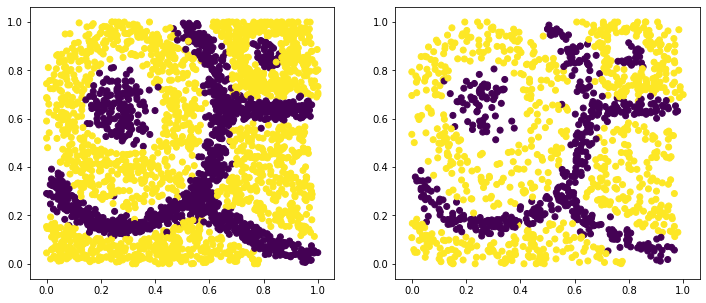

In [18]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.scatter(x_train[_X], x_train[_Y], c=y_train)

fig.add_subplot(122)

plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid)
plt.show()

In [19]:
train_ds = TD(T(x_train), T(y_train))
train_dl = DL(train_ds, batch_size=64, shuffle=True)

valid_ds = TD(T(x_valid), T(y_valid))
valid_dl = DL(valid_ds, batch_size=64, shuffle=False)

In [20]:
class NN(nn.Module):
    
    def __init__(self, num_hyperplanes):
        super().__init__()
        self.main = nn.Sequential(
            
            nn.Linear(2, num_hyperplanes),
            nn.BatchNorm1d(num_hyperplanes),  # maintain health gradient flow
            nn.Sigmoid(),
            
            nn.Linear(num_hyperplanes, 1),  # maintain health gradient flow
            nn.BatchNorm1d(1),
            nn.Sigmoid(),
        
        )
    
    def forward(self, xb):
        xb = self.main(xb)
        return xb.view(-1)

In [21]:
def get_model(num_hyperplanes):
    nn = NN(num_hyperplanes)
    return nn, optim.Adam(nn.parameters(), lr=10)

## Train a neural network

In [22]:
import sys
sys.path.append('../modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback, AccuracyCallback
from trainer import Trainer

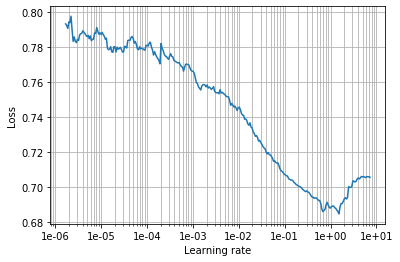

In [18]:
model, opt = get_model(200)
loss = nn.BCELoss()
learn = Learner(train_dl, valid_dl, model, loss, opt)

loss_cb = LossCallback()
acc_cb = AccuracyCallback()
cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

trainer = Trainer(learn=learn, cb_handler=cb_handler)

trainer.find_lr(beta=0.98, final_value=10, num_itr=300)

In [19]:
trainer.set_lr(4 * 1e-02)

In [20]:
trainer.train(500)

In [22]:
trainer.save_as_pth('./two_layer_network_universality.pth')

## Plot loss and accuracy over epoch

NameError: name 'loss_cb' is not defined

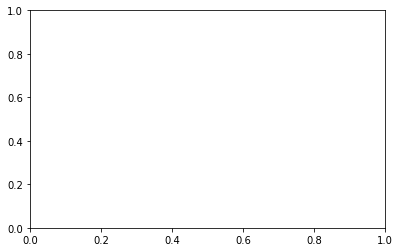

In [25]:
fig = plt.figure(figsize=(14, 4))

ax = fig.add_subplot(121)
loss_cb.plot()

fig.add_subplot(122)
acc_cb.plot()

plt.show() 

## Visualize decision boundary

In [270]:
model = get_model(200)[0]
model.load_state_dict(torch.load('./two_layer_network_universality.pth'), strict=False)

<All keys matched successfully>

In [271]:
xs = np.linspace(start=0, stop=1, num=100)
ys = xs.copy()
xxs, yys = np.meshgrid(xs, ys)
xxs, yys = xxs.flatten(), yys.flatten()
xxs.shape, yys.shape

((10000,), (10000,))

In [272]:
grid = np.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])
grid = T(grid)
grid.size()

torch.Size([10000, 2])

In [273]:
grid_values = model(grid.float()).detach().numpy()
grid_values.shape

(10000,)

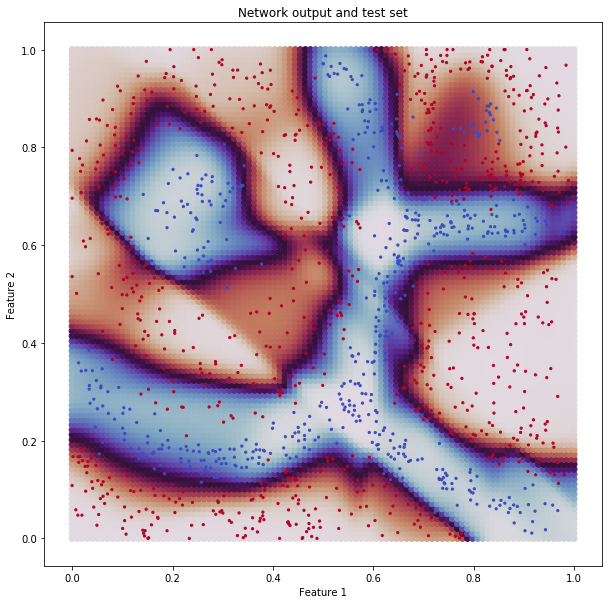

In [283]:
plt.figure(figsize=(10, 10))
plt.scatter(grid[_X], grid[_Y], c=grid_values, cmap='twilight')
plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid, s=5, cmap='coolwarm')
plt.title('Network output and test set')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
plt.show()

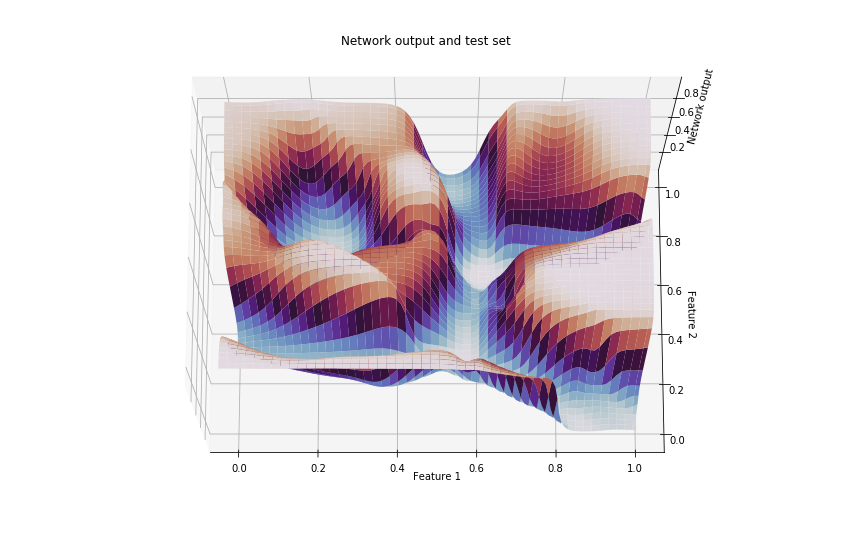

In [286]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid[_X].reshape(100, 100), grid[_Y].reshape(100, 100), 
                grid_values.reshape(100, 100), cmap='twilight')
ax.view_init(elev=75., azim=-90)

ax.set_title('Network output and test set')
ax.set_xlabel('Feature 1'); ax.set_ylabel('Feature 2'); ax.set_zlabel('Network output')

plt.show()

# Jacobian

In [234]:
grid.requires_grad = True
grid.grad = None

In [235]:
grid_values = model(grid.float())

In [236]:
grid.grad = None
for i, p in tqdm_notebook(list(enumerate(grid))):
    # since the ith output (grid_values[i]) is only dependent on the ith example,
    # grid.grad is filled rather than overwritten during the for loop
    grid_values[i].backward(retain_graph=True)

In [238]:
grid_grad_norms = np.linalg.norm(grid.grad.numpy(), axis=1)

In [250]:
with open('grid_grad_norms.json', 'w+') as json_f:
    json.dump(grid_grad_norms.tolist(), json_f)

In [251]:
with open('grid_grad_norms.json', 'r') as json_f:
    grid_grad_norms = np.array(json.load(json_f))

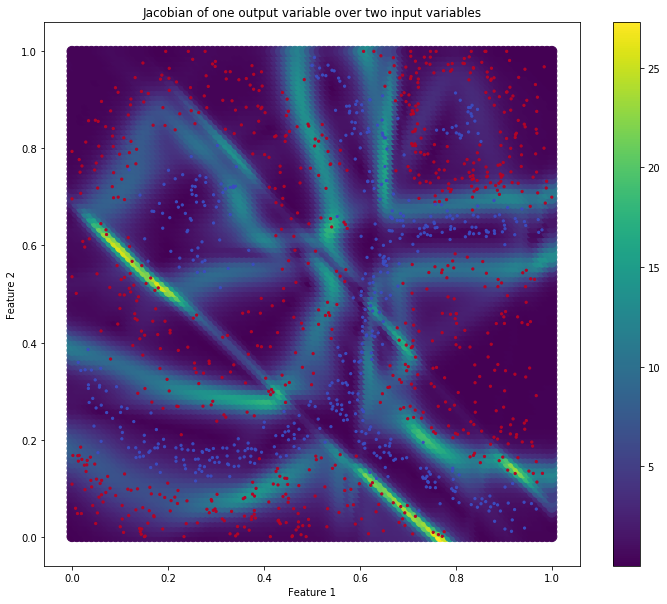

In [268]:
plt.figure(figsize=(12, 10))

plt.scatter(
    grid.detach()[_X], grid.detach()[_Y], 
    c=grid_grad_norms, s=100, cmap='viridis',
)
# jacobian

# viridis cmap has dark color for low values and light color on high values
# viridis is a perfect fit for this problem because we want to emphasize high values

plt.colorbar()

plt.scatter(x_valid[_X], x_valid[_Y], c=y_valid, s=5, cmap='coolwarm')  # test data

plt.title('Jacobian of one output variable over two input variables')
plt.xlabel('Feature 1'); plt.ylabel('Feature 2')

plt.show()